In [2]:
import pandas as pd
import numpy as np
import datetime
import pytz

from MakeSens import MakeSens
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rc('text',usetex=True)
plt.rc('font',size=16)

In [101]:
#fecha_inicio = "2023-06-11 00:00:00"
#fecha_fin = "2023-06-18 00:00:00"

# Rango de fecha
#fechaFin = datetime.datetime.now(pytz.timezone('America/Bogota')).strftime('%Y-%m-%d %H:%M:%S') # Fecha y hora Colombia
nowtime = datetime.datetime.combine(datetime.datetime.now(pytz.timezone('America/Bogota')), datetime.datetime.min.time())# Fecha y hora Colombia (medianoche)
fechaFin = nowtime.strftime('%Y-%m-%d %H:%M:%S') # Fecha y hora Colombia (medianoche)
#fechaInicio = fechaFin[:-8]+f'{int(fechaFin[-8:-6])-1:02}'+fechaFin[-6:] # Restar una hora

past_date =  nowtime - datetime.timedelta(days=6)  #Restar 6 días
fechaInicio = past_date.strftime('%Y-%m-%d %H:%M:%S')

Estaciones = [('E2_00023','Grupo Halley',7.1393716,-73.1210968),
            ('mE1_00004','Col. Tecnologico',7.1381572,-73.1180935),
            ('mE1_00005','Col. Santander',7.1385332,-73.121327),
            ('mE1_00007','Col. Normal',7.1277056,-73.116534),
            ('mE1_00006','Col. Pilar',7.108717813305484, -73.12173474310134),
            ('mE1_00008','Col. FundeUis',7.05756, -73.0912)]

frecuencia = "m"

#Descargamos los datos de MakeSens

In [102]:
wd = 30
ped = int(wd*0.1) 

def hour_mean(est):
    global pm25
    data = MakeSens.download_data(est, fechaInicio, fechaFin, frecuencia)
    
    if not data.empty:
        pm25 = data[["pm25_1", "pm25_2"]].copy(deep=True)
        pm25.index = pd.to_datetime(pm25.index) #Convertimos el indice a formato fecha
        
        pm25.pm25_1 = pm25.pm25_1.where(pm25.pm25_1 < 120, np.nan)
        pm25.pm25_2 = pm25.pm25_2.where(pm25.pm25_2 < 120, np.nan)
        
        pm25['pm25_1_r'] = pm25['pm25_1'].rolling(window=wd, min_periods=ped).mean() 
        pm25['pm25_2_r'] = pm25['pm25_2'].rolling(window = wd,min_periods=ped).mean()
        
        pm25['hour'] = pm25.index.hour
        
        hourly_1 = pm25.pm25_1_r.groupby(pm25.hour).mean()
        hourly_2 = pm25.pm25_2_r.groupby(pm25.hour).mean()
        
        data_final = ((hourly_1+hourly_2)/2.0).to_frame()
        
    else:
        pm25 = data
        data_final = data
    
    return data_final

In [103]:
Week = {
  1: "Lun",
  2: "Mar",
  3: "Mier",
  4: "Jue",
  5: "Vier",
  6: "Sab",
  7: "Dom"
}
Ntotal = int(24*30)

def day_mean(data,j):
    
    if not data.empty:
        data.dropna()
        pm25['day'] = pm25.index.day
        dfw = [ g for _,g in  data.groupby(data.day)]
        
        NN = len(dfw)
        pm25_grid = np.zeros(NN)
        day = []
        for i in range(NN):
            Ndata = dfw[i]['pm25_1'].count()
            day_p = dfw[i].index.isocalendar().day[0]
            
            number = dfw[i].day[0]
            day.append( " _ ".join([Week[day_p], str(number)]) )
            
            if Ndata>0.5*Ntotal:     
                pm25_grid[i] = np.mean([dfw[i]['pm25_1'].mean(),dfw[i]['pm25_2'].mean()])
            else:
                pm25_grid[i] = np.nan
                
        df2 = pd.DataFrame( [ np.array(pm25_grid) ],
                           columns=day)
        
        df2 = df2.set_index( pd.Index( [ Estaciones[j][1] ] ) )
    
    else:
        df2 = data
    
    return  df2

In [104]:
hr_0 = hour_mean(Estaciones[0][0])
hr_0.columns = [Estaciones[0][1]]

day_0 = day_mean(pm25,0)
#day_0 = day_0.set_index( pd.Index( [ Estaciones[0][1] ] ) )
#day_0.head()

In [105]:
Nest=len(Estaciones)

for i in range(1,Nest):
    print(Estaciones[i][1])
    hr_1 = hour_mean( Estaciones[i][0] )
    day_1 = day_mean(pm25,i)
    
    if not hr_1.empty:
        hr_1.columns = [ Estaciones[i][1] ] 
        hr_0 = hr_0.join(hr_1)
    
    if not day_1.empty:
        #day_1 = day_1.set_index( pd.Index( [ Estaciones[i][1] ] ) )
        #day_0  = day_0.reset_index()
        #day_1  = day_1.reset_index()
        day_0 = pd.concat([day_0, day_1])


Col. Tecnologico
Col. Santander
Col. Normal
Col. Pilar
Col. FundeUis


In [106]:
df_all_transposed = hr_0.transpose()

In [107]:
df_all_transposed.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Grupo Halley,13.591921,14.311077,14.496778,17.057833,17.726232,16.905293,14.372065,14.561942,11.410121,14.672477,...,30.659391,29.790633,17.261135,14.443456,12.291601,12.517270,11.389654,13.335768,12.473444,11.441880
Col. Tecnologico,7.161738,7.287973,7.006429,7.100629,7.780855,7.696509,7.434036,6.699080,6.266975,6.056135,...,11.752688,12.932285,13.480907,11.837987,10.593919,9.445862,8.691889,7.940066,7.698073,6.930828
Col. Normal,10.461378,11.941366,12.256589,13.489272,12.617148,11.822414,10.770809,9.215244,8.936952,9.688857,...,21.755077,20.101989,15.287356,11.364205,9.857157,10.171176,9.407567,9.616667,9.496373,9.215896
Col. Pilar,7.842627,8.856433,8.957304,10.158614,11.290130,10.832015,10.732210,11.855067,13.964304,14.059683,...,18.279609,13.233902,8.474345,7.511639,7.836759,8.215909,6.789568,8.371681,6.782481,6.624811
Col. FundeUis,5.472270,6.289266,6.880603,6.869888,6.491523,6.773305,6.005226,5.397557,5.776724,5.693503,...,15.616997,13.150790,8.248744,6.322958,7.899701,8.778571,7.828704,5.326782,5.178125,5.122707


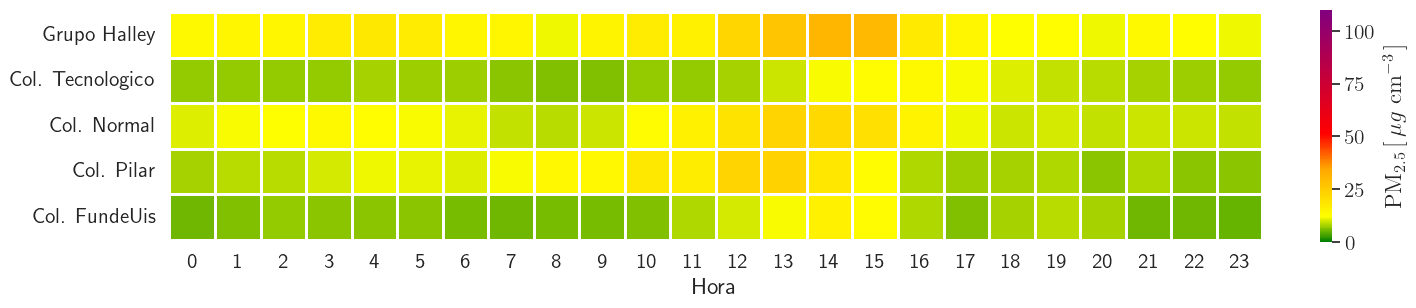

In [108]:
#cvals  = [6,12,37, 55, 100]
cvals  = [0,13, 38, 56, 120]
#colors = ['green', "#c8ff00", 'yellow', 'orange', "red"]
colors = ['green',  'yellow', 'orange', "red", "purple"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = LinearSegmentedColormap.from_list('name', tuples)
#cmap = ListedColormap(colors)

sns.set(font_scale=1.4)

plt.figure(figsize=(15,10), facecolor='w', edgecolor='k')
sns.heatmap(df_all_transposed,cmap=cmap,square=True, linewidths=2, vmin=0, vmax=110,
           cbar_kws={'fraction' : 0.01, 'label': '$\\mathrm{PM}_{2.5}\,  [\,\mu g\, \, \\mathrm{cm}^{-3}\,]$'})

plt.yticks(rotation=0) 
plt.xlabel('Hora')
plt.show()

In [109]:
day_0.head()

,Jue _ 22,Vier _ 23,Sab _ 24,Dom _ 25,Lun _ 26,Mar _ 27
Grupo Halley,22.627364,14.144368,13.918315,14.729510,17.197420,16.106411
Col. Tecnologico,13.318408,7.810855,6.297909,7.477201,8.199847,7.685581
Col. Normal,18.443149,11.926254,9.084058,13.340087,12.918221,11.373188
Col. Pilar,15.044668,13.496580,7.720816,12.183544,10.130435,11.711485
Col. FundeUis,NaN,NaN,6.388755,6.411638,6.582052,8.705000


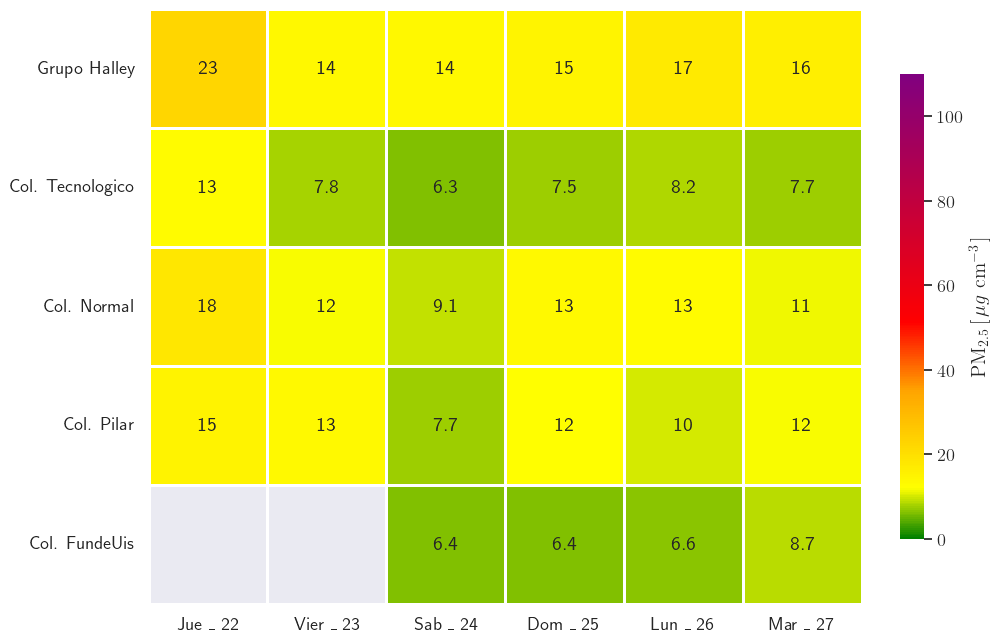

In [111]:
plt.figure(figsize=(10,8), facecolor='w', edgecolor='k')

sns.heatmap(day_0,cmap=cmap,square=True,linewidths=2, vmin=0, vmax=110, annot=True,
           cbar_kws={'fraction' : 0.03, 'label': '$\\mathrm{PM}_{2.5}\,  [\,\mu g\, \, \\mathrm{cm}^{-3}\,]$'})


sns.set(font_scale=1.2)

plt.yticks(rotation=0) 
#plt.xlabel('Hora')

plt.show()